# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans


pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 100)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
features_meta = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Previwing Datasets 

print("Features Dataset")
display(features_meta.head())

print("\nSample Azdias Dataset")
display(azdias.head())

print("\nSize of Azdidas Dataset: {}".format(azdias.shape[0]))
print("\nSize of Azdidas features Dataset: {}".format(features_meta.shape[0]))

Features Dataset


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]



Sample Azdias Dataset


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.000,3,4,3,5,5,3,4,0,10.000,0,-1,15.000,4.000,2.000,2.000,1.000,1.000,0,0,5.000,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,nan,nan,-1,3,nan,nan,nan,2.000,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,-1,1,2,5.000,1,5,2,5,4,5,1,1996,10.000,0,3,21.000,6.000,5.000,3.000,2.000,1.000,1,14,1.000,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.000,0.000,2,5,0.000,2.000,0.000,6.000,nan,3.000,9.000,11.000,0.000,8.000,1.000,1992.000,W,4.000,8,8A,51,0.000,0.000,0.000,2.000,5.000,1.000,6.000,3.000,8.000,3.000,2.000,1.000,3.000,3.000,963.000,2.000,3.000,2.000,1.000,1.000,5.000,4.000,3.000,5.000,4.000
2,-1,3,2,3.000,1,4,1,2,3,5,1,1979,10.000,1,3,3.000,1.000,1.000,1.000,3.000,2.000,1,15,3.000,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.000,0.000,1,5,17.000,1.000,0.000,4.000,nan,3.000,9.000,10.000,0.000,1.000,5.000,1992.000,W,2.000,4,4C,24,1.000,3.000,1.000,0.000,0.000,3.000,2.000,4.000,4.000,4.000,2.000,3.000,2.000,2.000,712.000,3.000,3.000,1.000,0.000,1.000,4.000,4.000,3.000,5.000,2.000
3,2,4,2,2.000,4,2,5,2,1,2,6,1957,1.000,0,2,0.000,0.000,0.000,0.000,9.000,4.000,1,8,2.000,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.000,0.000,1,3,13.000,0.000,0.000,1.000,nan,nan,9.000,1.000,0.000,1.000,4.000,1997.000,W,7.000,2,2A,12,4.000,1.000,0.000,0.000,1.000,4.000,4.000,2.000,6.000,4.000,0.000,4.000,1.000,0.000,596.000,2.000,2.000,2.000,0.000,1.000,3.000,4.000,2.000,3.000,3.000
4,-1,3,1,5.000,4,3,4,1,3,2,5,1963,5.000,0,3,32.000,10.000,10.000,5.000,3.000,2.000,1,8,5.000,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.000,0.000,2,4,20.000,4.000,0.000,5.000,1.000,2.000,9.000,3.000,0.000,1.000,4.000,1992.000,W,3.000,6,6B,43,1.000,4.000,1.000,0.000,0.000,3.000,2.000,5.000,1.000,5.000,3.000,3.000,5.000,5.000,435.000,2.000,4.000,2.000,1.000,2.000,3.000,3.000,4.000,6.000,5.000



Size of Azdidas Dataset: 891221

Size of Azdidas features Dataset: 85


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# NANs before conversion coded 'missing' or 'unknown' values

nans = azdias.isnull().sum().sort_values(ascending = False) 
display(nans[nans > 0])

print("Total numbers of columns with missing values : {}".format(len(nans[nans > 0])))

KK_KUNDENTYP           584612
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ              133324
MOBI_REGIO             133324
REGIOTYP               121196
KKK                    121196
PLZ8_ANTG3             116515
PLZ8_ANTG1             116515
PLZ8_GBZ               116515
PLZ8_ANTG2             116515
PLZ8_HHZ               116515
PLZ8_BAUMAX            116515
PLZ8_ANTG4             116515
W_KEIT_KIND_HH         107602
KBA13_ANZAHL_PKW       105800
CAMEO_INTL_2015         98979
CAMEO_DEU_2015          98979
CAMEO_DEUG_2015         98979
ORTSGR_KLS9             97216
ARBEIT                  97216
RELAT_AB                97216
ANZ_HH_TITEL            97008
BALLRAUM                93740
EWDICHTE                93740
INNENSTADT              93740
GEBAEUDETYP_RASTER      93155
ANZ_HAUSHALTE_AKTIV     93148
GEBAEUDETYP             93148
MIN_GEBAEUDEJAHR        93148
OST_WEST_K

Total numbers of columns with missing values : 53


In [5]:
# Identify encoded missing or unknown data values and convert them to NaNs.

def replace_missing(features_meta, col):
    missing_values = features_meta[features_meta['attribute'] == col]['missing_or_unknown']
    missing_values = missing_values.item()
    missing_values = missing_values.strip("]").strip("[").split(",")
    missing_values = [int(value) for value in missing_values if value.isnumeric() or value.lstrip('-').isnumeric()]
    missing_values = dict((k, np.nan) for k in missing_values)
    return missing_values

for col in azdias.columns:
    missing_dict = replace_missing(features_meta, col)
    azdias[col] = azdias[col].replace(missing_dict)
    


In [6]:
azdias['TITEL_KZ'].isnull().sum() / len(azdias['TITEL_KZ'])

0.9975763587258379

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

null_df = pd.DataFrame({'count':azdias.isnull().sum(), 'perc':azdias.isnull().sum()/len(azdias)}).reset_index()
null_df = null_df.rename(columns = {'index':'column_name'})

In [8]:
null_df = null_df.sort_values(by = 'perc', ascending=False)
null_df = null_df[null_df['count'] != 0] # Considering columns only with missing values 

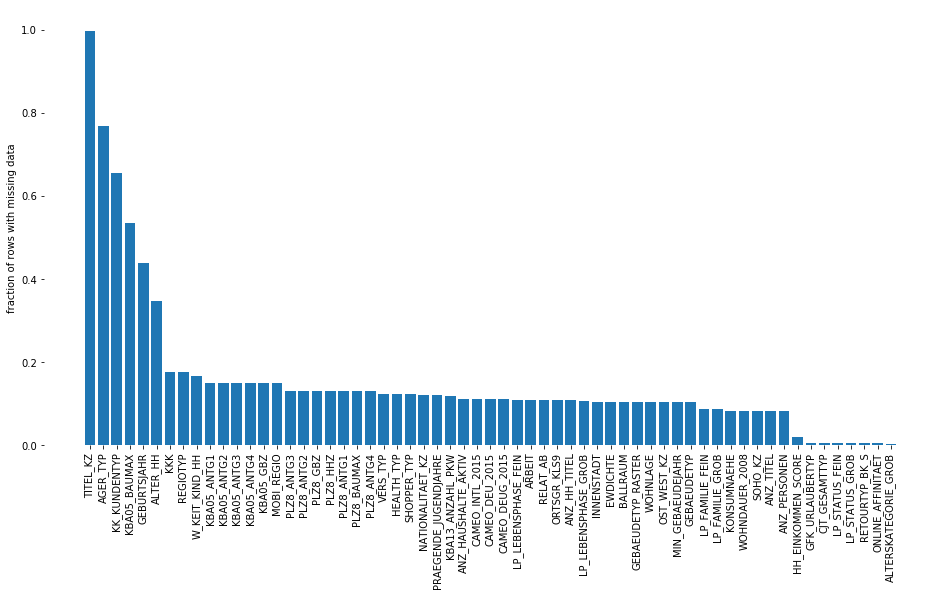

In [9]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_df)),null_df.column_name,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_df)),null_df.perc)
plt.box(on=False);

In [10]:
null_df

,column_name,count,perc
40,TITEL_KZ,889061,0.998
0,AGER_TYP,685843,0.770
47,KK_KUNDENTYP,584612,0.656
64,KBA05_BAUMAX,476524,0.535
11,GEBURTSJAHR,392318,0.440
43,ALTER_HH,310267,0.348
70,KKK,158064,0.177
73,REGIOTYP,158064,0.177
48,W_KEIT_KIND_HH,147988,0.166
60,KBA05_ANTG1,133324,0.150


In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# remove selected columns and rows, ...
cols_dropped = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
azdias = azdias.drop(cols_dropped, axis = 1, errors = 'ignore')

#### Discussion 1.1.2: Assess Missing Data in Each Column

Cleaning the data by handling missing values is a significant step in modeling. This will help us in creating cleaner boundaries in clustering by avoiding observations which are either outliers or points which don't provide any learning to the model 

Column `TITEL_KZ` has ~99.8% of missing values , `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`,`GEBURTSJAHR`,`ALTER_HH` also has high amount of missing values(more than 20%) and hence safe assumption can be made that these features doesn't contribute much to the clustering and hence has been dropped from feature dataset

All the features given in the dataset are broadly divided into 9 groups based on the similarity characteristic shared by the features.

1. Consumer pattern over last 12 months(KK_KUNDENTYP) is features with highest missing values.
2. Columns begining with `KBA05_` all could be grouped under RR3 Micro-cell features. This group tend to have missing values occuring consistently across the grouped columns. This could mean that some observations about RR3 Micro-cell features were not taken at all. Same is the case with columns starting with `PLZ8_` and `CAMEO_`
3. There are 24 columns with no missing values at all. Most of them are grouped under `FINANZ_` and `SEMIO_`

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?


In [13]:
null_df_rows = pd.DataFrame(azdias.isnull().sum(axis=1)).reset_index()
null_df_rows.columns = ['row_number','nulls']
null_df_rows['perc'] = 100 * null_df_rows['nulls']/len(azdias.columns)

In [14]:
def row_missing_values_counter(threshold,null_df_rows):
    count_rows_with_na = null_df_rows[null_df_rows['perc'] >= threshold].shape[0]
    count_rows_with_na_perc = 100 * count_rows_with_na/null_df_rows.shape[0]
    return count_rows_with_na, str(round(count_rows_with_na_perc, 2)) + '%'
    
for i in range(10, 110, 10):
    print("Size of data with {}% missing values from rows = {}".format(i, row_missing_values_counter(i, null_df_rows)))

    
count_rows_with_na, _ = row_missing_values_counter(20, null_df_rows)


print("\n\nTotal rows : {}".format(azdias.shape[0]))
print("Total rows with less than 20% " \
      "of missing values : {}".format(count_rows_with_na))
print("Percentage of rows with less than 20% " \
      "of missing values : {}".format(100 * count_rows_with_na/null_df_rows.shape[0]))

Size of data with 10% missing values from rows = (144059, '16.16%')
Size of data with 20% missing values from rows = (98904, '11.1%')
Size of data with 30% missing values from rows = (93382, '10.48%')
Size of data with 40% missing values from rows = (93151, '10.45%')
Size of data with 50% missing values from rows = (74113, '8.32%')
Size of data with 60% missing values from rows = (3, '0.0%')
Size of data with 70% missing values from rows = (0, '0.0%')
Size of data with 80% missing values from rows = (0, '0.0%')
Size of data with 90% missing values from rows = (0, '0.0%')
Size of data with 100% missing values from rows = (0, '0.0%')


Total rows : 891221
Total rows with less than 20% of missing values : 98904
Percentage of rows with less than 20% of missing values : 11.097584100913242


In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Creating two new data frame where one dataframe has no more than 20% of values in a row missing and other one has less than

low_missing_20 = azdias[azdias.isnull().sum(axis=1) < round((0.2  * len(azdias.columns))) ].reset_index(drop=True)
high_missing_20 = azdias[azdias.isnull().sum(axis=1) >= round((0.2  * len(azdias.columns)))].reset_index(drop=True)

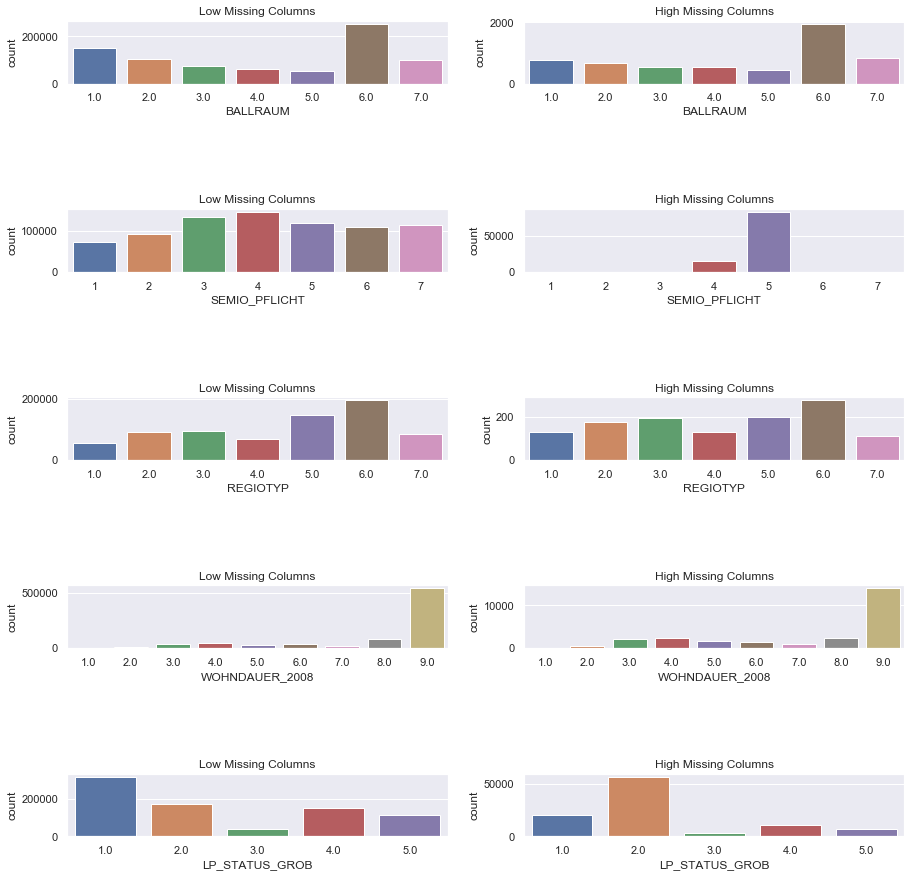

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def randomized_dist_cols(low_missing_df, high_missing_df, columns, number_of_columns):
    sns.set(style="darkgrid")
    random.seed(12)
    sub_columns = random.sample(columns, number_of_columns)
    fig, ax = plt.subplots(number_of_columns,2, figsize=(15, 15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace =2 , wspace=.2)
    ax = ax.ravel()
    
    for i, col in enumerate(sub_columns):
        sns.countplot(x=col, data=low_missing_df, ax = ax[i * 2])
        ax[i*2].set_title('Low Missing Columns')
        sns.countplot(x=col, data=high_missing_20, ax = ax[i * 2 + 1])
        ax[i*2 + 1].set_title('High Missing Columns')

randomized_dist_cols(low_missing_20, high_missing_20, list(low_missing_20.columns), 5)

In [17]:
#filling missing values with the median if that is numerical else, 

for col in low_missing_20.columns:
    numeric_cols = low_missing_20.select_dtypes(include=['int64','float64']).columns
    if col in numeric_cols: 
        low_missing_20[col] = low_missing_20[col].fillna(low_missing_20[col].median())
    else:
        print(col)
        low_missing_20[col] = low_missing_20[col].fillna(low_missing_20[col].mode())

OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015


In [18]:
low_missing_20.CAMEO_INTL_2015.mode()

0    51
dtype: object

#### Discussion 1.1.3: Assess Missing Data in Each Row

Missing values handling should be in such as way that there should not be many missing value creating a spare data set which doesn't add any value but it adds computational load and also there should not be too much missing information by exclusion of all the null values. Just checking from the basic counts of how many values are missing from each row, I conisdered 40% a threshold value. So, if there are more than 40% of values missing from a row then we exclude that row. This way I will be losing ~10% of the data which is not too much. Also, distribution of the low_missing and high_missing is not that different and hence there will not be much loss in information that way

It is better to have few missing values in the dataset becuase while clustering it would be good to have clusters with clean boundaries and no outliers or minimum outliers

For rest of the data, I chose to impute the dataset with median of that column if they are numeric columns else filling with mode 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?

features_meta.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [20]:
# What are these object columns?

print("#### Feature Types #### ")
display(low_missing_20.dtypes.value_counts(normalize=True))


print("### Features with Object Datatype")
objects = low_missing_20.dtypes.where(low_missing_20.dtypes == 'object')
objects = objects[objects.notnull()]
display(objects)

#### Feature Types #### 


float64   0.646
int64     0.304
object    0.051
dtype: float64

### Features with Object Datatype


OST_WEST_KZ        object
CAMEO_DEUG_2015    object
CAMEO_DEU_2015     object
CAMEO_INTL_2015    object
dtype: object

In [21]:
features_meta[features_meta['attribute'].isin(objects.index)]

,attribute,information_level,type,missing_or_unknown
55,OST_WEST_KZ,building,categorical,[-1]
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]"
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


They are non numerical categorical variable, hence we can leave them as is without changing the data types

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_binary = []
categorical_non_binary = []
cat_features = features_meta[features_meta['type'] == 'categorical']['attribute']
cat_features = [col for col in cat_features if col not in cols_dropped]
for col in cat_features:
    if len(low_missing_20[col].unique()) <= 2:
        categorical_binary.append(col)
    else:
        categorical_non_binary.append(col)

In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.


categorical_non_binary_df = low_missing_20[categorical_non_binary]
low_missing_20 = low_missing_20.drop(categorical_non_binary, axis =1 )
categorical_non_binary_df = pd.get_dummies(categorical_non_binary_df)

In [24]:
low_missing_20  = pd.concat([low_missing_20, categorical_non_binary_df], axis = 1)

In [25]:
low_missing_20[categorical_binary].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,2,0,1.000,2.000,W
1,2,1,0.000,1.000,W
2,2,0,0.000,1.000,W
3,1,0,0.000,2.000,W
4,2,0,0.000,2.000,W


In [26]:
low_missing_20['OST_WEST_KZ'].value_counts()

W    624758
O    167559
Name: OST_WEST_KZ, dtype: int64

In [27]:
# Encoding W with 1 and  O with 0

mapping = {"W":1,"O":0}
low_missing_20['OST_WEST_KZ'] = low_missing_20['OST_WEST_KZ'].map(mapping)
low_missing_20['OST_WEST_KZ'].value_counts()

1    624758
0    167559
Name: OST_WEST_KZ, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features



Instead of dropping the columns, I chose to create dummy variables for categorical columns. This is performed by seperating catergorical columns from the entire dataset, use pd.get_dummies function from pandas and concat the encode features into our dataframe. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE"and engineer two new variables.

def east_west(row):
    if row in [6,10, 11]:
        return  'w'
    elif row in [7, 12, 13]:
        return 'e'
    else:
        return 'e+w'
    
def main_avant(row):
    if row in [1,3,5, 8, 10,12, 14]:
        return  'mainstream'
    else:
        return 'avantgarde'


low_missing_20['eastwest']  = low_missing_20['PRAEGENDE_JUGENDJAHRE'].apply(east_west) 
low_missing_20['mainavant']  = low_missing_20['PRAEGENDE_JUGENDJAHRE'].apply(main_avant) 

In [29]:
mapping_decade = {1:40,2:40,3:50,4:50,5:60,6:60,7:60, 8:70,9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
low_missing_20['decade'] = low_missing_20['PRAEGENDE_JUGENDJAHRE'].map(mapping_decade)

In [30]:
low_missing_20['CAMEO_INTL_2015'] = low_missing_20['CAMEO_INTL_2015'].replace({'XX':-1})
low_missing_20['CAMEO_INTL_2015'] = low_missing_20['CAMEO_INTL_2015'].astype(float)
low_missing_20['CAMEO_INTL_2015'] = low_missing_20['CAMEO_INTL_2015'].fillna(low_missing_20['CAMEO_INTL_2015'].mode())

def split_ones_tens(row, select):
    return  divmod(row, 10)[select]

low_missing_20['WEALTH'] = low_missing_20['CAMEO_INTL_2015'].apply(split_ones_tens, args = (0, ))
low_missing_20['AGE_GROUP'] = low_missing_20['CAMEO_INTL_2015'].apply(split_ones_tens, args = (1, ))

In [31]:
#Dropping columns which are encoded 

low_missing_20 = low_missing_20.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'], axis = 1)

In [32]:
#  Creating dummies for new columns

low_missing_20 = pd.get_dummies(low_missing_20, columns = ['eastwest','mainavant'])

In [33]:
for col in features_meta[features_meta['type'] == 'mixed']['attribute']:
    try: 
        print(col, ":" ,len(low_missing_20[col].unique()))
    except: 
        pass

LP_LEBENSPHASE_FEIN : 40
LP_LEBENSPHASE_GROB : 12
WOHNLAGE : 8
PLZ8_BAUMAX : 5


In [35]:
# # Converting birth year into year since birth. 

# low_missing_20['YEARS_SINCE_BIRTH'] =  2018 - low_missing_20['GEBURTSJAHR'] 
# low_missing_20['YEARS_SINCE_BIRTH'] = low_missing_20['YEARS_SINCE_BIRTH'].replace(2018, low_missing_20['YEARS_SINCE_BIRTH'].median())
# low_missing_20 = low_missing_20.drop('GEBURTSJAHR', axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Four new columns are created here. 'CAMEO_INTL_2015' was an 'object' data type. So, It has been converted to float to deal with NAs in that column.Also, dummies columns are created for new set of columns. 'GEBURTSJAHR' is year of birth which is converted into number of years since birth to fill rows with 0 as value with  median. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

low_missing_20.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,...,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,decade,WEALTH,AGE_GROUP,eastwest_e,eastwest_e+w,eastwest_w,mainavant_avantgarde,mainavant_mainstream
0,1.000,2,1,5,2,5,4,5,0,3.000,21.000,6.000,1.000,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.000,2.000,2.000,0.000,6.000,3.000,9.000,11.000,0.000,1.000,1992.000,1,4.000,0.000,0.000,0.000,2.000,1.000,6.000,3.000,8.000,3.000,2.000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,90,5.000,1.000,0,1,0,0,1
1,3.000,2,1,4,1,2,3,5,1,3.000,3.000,1.000,3.000,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.000,1.000,1.000,0.000,4.000,3.000,9.000,10.000,0.000,5.000,1992.000,1,2.000,1.000,3.000,1.000,0.000,3.000,2.000,4.000,4.000,4.000,2.000,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,2.000,4.000,0,1,0,1,0
2,4.000,2,4,2,5,2,1,2,0,2.000,13.000,3.000,2.000,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.000,1.000,0.000,0.000,1.000,4.000,9.000,1.000,0.000,4.000,1997.000,1,7.000,4.000,1.000,0.000,0.000,4.000,4.000,2.000,6.000,4.000,3.000,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,1.000,2.000,0,1,0,0,1
3,3.000,1,4,3,4,1,3,2,0,3.000,32.000,10.000,5.000,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.000,2.000,4.000,0.000,5.000,2.000,9.000,3.000,0.000,4.000,1992.000,1,3.000,1.000,4.000,1.000,0.000,3.000,2.000,5.000,1.000,5.000,3.000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,4.000,3.000,0,1,0,0,1
4,1.000,2,3,1,5,2,2,5,0,3.000,8.000,2.000,3.000,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.000,2.000,1.000,0.000,5.000,6.000,9.000,5.000,0.000,5.000,1992.000,1,7.000,2.000,2.000,0.000,0.000,4.000,6.000,2.000,7.000,4.000,4.000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,50,5.000,4.000,0,1,0,0,1


In [37]:
# Any NAs left?

missing_value_cols = low_missing_20.isnull().sum() > 0
missing_value_cols[missing_value_cols == True]

WEALTH       True
AGE_GROUP    True
dtype: bool

In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

for col in ['WEALTH','AGE_GROUP']:
    low_missing_20[col] = low_missing_20[col].fillna(low_missing_20[col].median())

# low_missing_20['OST_WEST_KZ'] = low_missing_20['OST_WEST_KZ'].astype(str)
# low_missing_20 = pd.get_dummies(low_missing_20, columns= ['OST_WEST_KZ'])    

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    nans = azdias.isnull().sum().sort_values(ascending = False) 
    display(nans[nans > 0])

    
    for col in azdias.columns:
        missing_dict = replace_missing(features_meta, col)
        azdias[col] = azdias[col].replace(missing_dict)
    
    null_df = pd.DataFrame({'count':azdias.isnull().sum(), 'perc':azdias.isnull().sum()/len(azdias)}).reset_index()
    null_df = null_df.rename(columns = {'index':'column_name'})
    null_df = null_df.sort_values(by = 'perc', ascending=False)
    null_df = null_df[null_df['count'] != 0] # Considering columns only with missing values 


    # remove selected columns and rows, ...
    cols_dropped = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    azdias = azdias.drop(cols_dropped, axis = 1, errors = 'ignore')
    
    null_df_rows = pd.DataFrame(azdias.isnull().sum(axis=1)).reset_index()
    null_df_rows.columns = ['row_number','nulls']
    null_df_rows['perc'] = 100 * null_df_rows['nulls']/len(azdias.columns)


    low_missing_20 = azdias[azdias.isnull().sum(axis=1) < round((0.2  * len(azdias.columns))) ].reset_index(drop=True)
    high_missing_20 = azdias[azdias.isnull().sum(axis=1) >= round((0.2  * len(azdias.columns)))].reset_index(drop=True)


    
    # select, re-encode, and engineer column values.

    for col in low_missing_20.columns:
        numeric_cols = low_missing_20.select_dtypes(include=['int64','float64']).columns
        if col in numeric_cols: 
            low_missing_20[col] = low_missing_20[col].fillna(low_missing_20[col].median())
        else:
            print(col)
            low_missing_20[col] = low_missing_20[col].fillna(low_missing_20[col].mode())


    print("### Features with Object Datatype")
    objects = low_missing_20.dtypes.where(low_missing_20.dtypes == 'object')
    objects = objects[objects.notnull()]
    display(objects)

    categorical_binary = []
    categorical_non_binary = []
    cat_features = features_meta[features_meta['type'] == 'categorical']['attribute']
    cat_features = [col for col in cat_features if col not in cols_dropped]
    for col in cat_features:
        if len(low_missing_20[col].unique()) <= 2:
            categorical_binary.append(col)
        else:
            categorical_non_binary.append(col)
            
    
    categorical_non_binary_df = low_missing_20[categorical_non_binary]
    low_missing_20 = low_missing_20.drop(categorical_non_binary, axis =1 )
    categorical_non_binary_df = pd.get_dummies(categorical_non_binary_df)

    mapping = {"W":1,"O":0}
    low_missing_20['OST_WEST_KZ'] = low_missing_20['OST_WEST_KZ'].replace(mapping)
    
    low_missing_20  = pd.concat([low_missing_20, categorical_non_binary_df], axis = 1)
    low_missing_20['eastwest']  = low_missing_20['PRAEGENDE_JUGENDJAHRE'].apply(east_west) 
    low_missing_20['mainavant']  = low_missing_20['PRAEGENDE_JUGENDJAHRE'].apply(main_avant) 
    mapping_decade = {1:40,2:40,3:50,4:50,5:60,6:60,7:60, 8:70,9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    low_missing_20['decade'] = low_missing_20['PRAEGENDE_JUGENDJAHRE'].map(mapping_decade)
    low_missing_20['CAMEO_INTL_2015'] = low_missing_20['CAMEO_INTL_2015'].replace({'XX':-1})
    low_missing_20['CAMEO_INTL_2015'] = low_missing_20['CAMEO_INTL_2015'].astype(float)
    low_missing_20['CAMEO_INTL_2015'] = low_missing_20['CAMEO_INTL_2015'].fillna(low_missing_20['CAMEO_INTL_2015'].mode())
    low_missing_20['WEALTH'] = low_missing_20['CAMEO_INTL_2015'].apply(split_ones_tens, args = (0, ))
    low_missing_20['AGE_GROUP'] = low_missing_20['CAMEO_INTL_2015'].apply(split_ones_tens, args = (1, ))
    low_missing_20 = low_missing_20.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'], axis = 1)
    low_missing_20 = pd.get_dummies(low_missing_20, columns = ['eastwest','mainavant'])

    for col in features_meta[features_meta['type'] == 'mixed']['attribute']:
        try: 
            print(col, ":" ,len(low_missing_20[col].unique()))
        except: 
            pass

#     low_missing_20['YEARS_SINCE_BIRTH'] =  2018 - low_missing_20['GEBURTSJAHR'] 
#     low_missing_20['YEARS_SINCE_BIRTH'] = low_missing_20['YEARS_SINCE_BIRTH'].replace(2018, low_missing_20['YEARS_SINCE_BIRTH'].median())
#     low_missing_20 = low_missing_20.drop('GEBURTSJAHR', axis = 1)
    
    for col in ['WEALTH','AGE_GROUP']:
        low_missing_20[col] = low_missing_20[col].fillna(low_missing_20[col].median())

#     low_missing_20['OST_WEST_KZ'] = low_missing_20['OST_WEST_KZ'].astype(str)
#     low_missing_20 = pd.get_dummies(low_missing_20, columns= ['OST_WEST_KZ'])    

    # Retrun the clean dataframe
    return low_missing_20, high_missing_20

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

missing_value_cols = low_missing_20.isnull().sum() > 0
missing_value_cols[missing_value_cols == True]

Series([], dtype: bool)

There are no missing values

In [42]:
# Apply feature scaling to the general population demographics data.

scale = StandardScaler()
azdias_scaled = scale.fit_transform(low_missing_20)
azdias_scaled = pd.DataFrame(azdias_scaled, columns = low_missing_20.columns)

In [43]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,...,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,decade,WEALTH,AGE_GROUP,eastwest_e,eastwest_e+w,eastwest_w,mainavant_avantgarde,mainavant_mainstream
0,-1.767,0.958,-1.493,1.539,-1.042,1.467,0.966,1.335,-0.531,1.094,0.412,0.318,-1.685,0.440,-0.058,0.004,-0.460,-1.685,-1.113,-1.437,-0.580,1.275,-0.311,1.338,-0.158,1.515,1.289,10.859,0.920,0.233,-0.061,1.021,-0.674,0.562,0.169,-0.125,-1.303,-0.386,0.518,-0.031,-1.070,-1.029,-0.598,2.720,-1.654,0.847,-0.549,1.702,-0.799,-0.789,...,-0.123,-0.080,-0.130,-0.141,-0.158,-0.215,-0.113,-0.095,-0.214,-0.212,-0.208,-0.107,-0.253,-0.104,-0.082,-0.123,-0.115,-0.112,-0.138,-0.067,-0.074,-0.093,-0.277,-0.138,-0.088,-0.144,-0.083,-0.213,-0.178,-0.107,-0.082,-0.076,3.760,-0.210,-0.202,-0.150,-0.163,-0.190,-0.180,-0.193,-0.090,-0.021,1.174,1.183,-1.261,-0.212,0.543,-0.476,-0.585,0.585
1,0.200,0.958,-1.493,0.865,-1.768,-0.570,0.250,1.335,1.883,1.094,-1.103,-1.046,-0.307,-0.075,-1.628,-0.520,-0.460,-0.141,-0.162,0.753,-0.580,0.066,1.398,1.338,1.448,-0.636,-0.411,-0.092,-1.087,-0.632,-0.061,-0.274,-0.674,0.562,0.105,-0.125,1.277,-0.386,0.518,-1.062,-0.343,1.433,0.403,-0.466,-0.117,-0.985,0.033,-0.270,0.285,-0.789,...,-0.123,-0.080,-0.130,-0.141,-0.158,-0.215,-0.113,-0.095,-0.214,-0.212,-0.208,-0.107,3.959,-0.104,-0.082,-0.123,-0.115,-0.112,-0.138,-0.067,-0.074,-0.093,-0.277,-0.138,-0.088,-0.144,-0.083,-0.213,-0.178,-0.107,-0.082,-0.076,-0.266,-0.210,-0.202,-0.150,-0.163,-0.190,-0.180,-0.193,-0.090,-0.021,1.174,-0.865,0.756,-0.212,0.543,-0.476,1.710,-1.710
2,1.183,0.958,0.685,-0.481,1.137,-0.570,-1.181,-0.800,-0.531,-0.259,-0.261,-0.500,-0.996,0.440,-1.628,-1.043,-1.505,-0.141,-0.162,1.301,-0.069,-0.539,-0.311,-0.305,0.377,-0.099,0.156,-0.092,-1.087,-1.496,-0.061,-2.218,-0.090,0.562,-0.470,-0.125,0.632,1.270,0.518,1.516,1.836,-0.208,-0.598,-0.466,0.652,-0.069,-1.131,0.716,0.285,0.270,...,-0.123,-0.080,7.702,-0.141,-0.158,-0.215,-0.113,-0.095,-0.214,-0.212,-0.208,-0.107,-0.253,-0.104,-0.082,-0.123,-0.115,-0.112,-0.138,-0.067,-0.074,-0.093,-0.277,-0.138,-0.088,-0.144,-0.083,-0.213,-0.178,-0.107,-0.082,-0.076,-0.266,-0.210,-0.202,-0.150,-0.163,-0.190,-0.180,-0.193,-0.090,-0.021,-0.222,-1.548,-0.589,-0.212,0.543,-0.476,-0.585,0.585
3,0.200,-1.044,0.685,0.192,0.411,-1.249,0.250,-0.800,-0.531,1.094,1.338,1.410,1.071,0.955,-0.058,0.004,-0.983,1.403,-0.162,-0.342,0.953,-1.144,-0.880,-1.400,-1.228,-0.099,-0.978,-0.092,0.920,1.961,-0.061,0.374,-1.258,0.562,-0.342,-0.125,0.632,-0.386,0.518,-0.546,-0.343,2.253,0.403,-0.466,-0.117,-0.985,0.616,-1.749,1.369,0.270,...,-0.123,-0.080,-0.130,-0.141,-0.158,-0.215,-0.113,-0.095,-0.214,-0.212,-0.208,-0.107,-0.253,-0.104,-0.082,-0.123,

### Discussion 2.1: Apply Feature Scaling

Checked for missing values. There is none present. All missing values are taken care in the cleaning process. Here standard scaling is done to normalize the values  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.


pca = PCA(random_state=12)
azdias_scaled_pca = pca.fit_transform(azdias_scaled)

In [45]:
azdias_scaled_pca =  pd.DataFrame(azdias_scaled_pca, columns = azdias_scaled.columns)

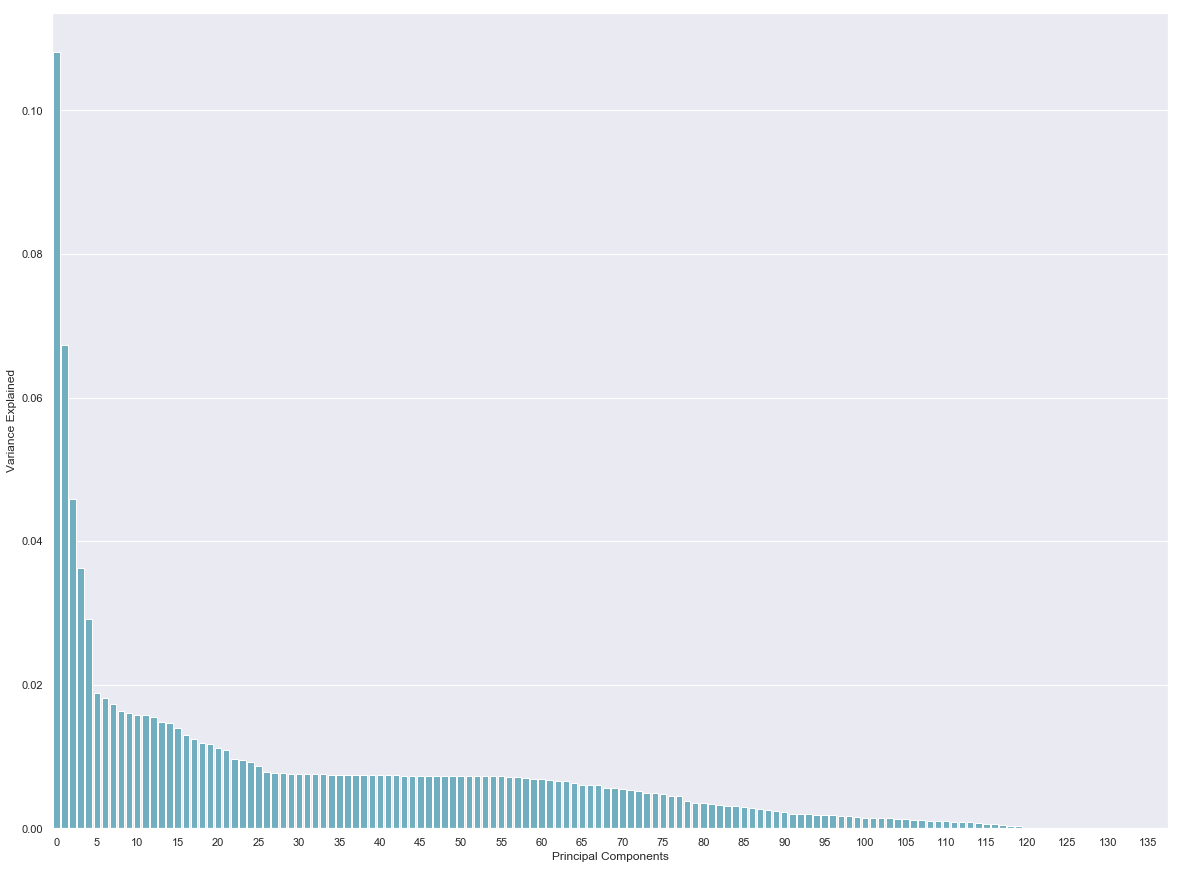

In [46]:

x_values = [x+1 for x in range(len(azdias_scaled_pca.columns))]

pca_evr_df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':x_values})
plt.figure(figsize=(20, 15))

ax = sns.barplot(x='PC',y="var", 
           data=pca_evr_df, color="c");


ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel("Principal Components")
ax.set_ylabel("Variance Explained")

plt.show()

In [47]:
pca_evr_df['explained_variance_cumsum'] = np.cumsum(pca_evr_df['var'])
pca_evr_df = pca_evr_df[pca_evr_df['explained_variance_cumsum'] <= 0.85]
pca_evr_df

,var,PC,explained_variance_cumsum
0,0.108,1,0.108
1,0.067,2,0.175
2,0.046,3,0.221
3,0.036,4,0.258
4,0.029,5,0.287
5,0.019,6,0.306
6,0.018,7,0.324
7,0.017,8,0.341
8,0.016,9,0.357
9,0.016,10,0.373


In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=65, random_state= 12)
azdias_scaled_pca = pca.fit_transform(low_missing_20)
azdias_scaled_pca = pd.DataFrame(azdias_scaled_pca)

In [49]:
low_missing_20.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,...,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,decade,WEALTH,AGE_GROUP,eastwest_e,eastwest_e+w,eastwest_w,mainavant_avantgarde,mainavant_mainstream
0,1.000,2,1,5,2,5,4,5,0,3.000,21.000,6.000,1.000,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.000,2.000,2.000,0.000,6.000,3.000,9.000,11.000,0.000,1.000,1992.000,1,4.000,0.000,0.000,0.000,2.000,1.000,6.000,3.000,8.000,3.000,2.000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,90,5.000,1.000,0,1,0,0,1
1,3.000,2,1,4,1,2,3,5,1,3.000,3.000,1.000,3.000,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.000,1.000,1.000,0.000,4.000,3.000,9.000,10.000,0.000,5.000,1992.000,1,2.000,1.000,3.000,1.000,0.000,3.000,2.000,4.000,4.000,4.000,2.000,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,2.000,4.000,0,1,0,1,0
2,4.000,2,4,2,5,2,1,2,0,2.000,13.000,3.000,2.000,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.000,1.000,0.000,0.000,1.000,4.000,9.000,1.000,0.000,4.000,1997.000,1,7.000,4.000,1.000,0.000,0.000,4.000,4.000,2.000,6.000,4.000,3.000,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,1.000,2.000,0,1,0,0,1
3,3.000,1,4,3,4,1,3,2,0,3.000,32.000,10.000,5.000,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.000,2.000,4.000,0.000,5.000,2.000,9.000,3.000,0.000,4.000,1992.000,1,3.000,1.000,4.000,1.000,0.000,3.000,2.000,5.000,1.000,5.000,3.000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,4.000,3.000,0,1,0,0,1
4,1.000,2,3,1,5,2,2,5,0,3.000,8.000,2.000,3.000,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.000,2.000,1.000,0.000,5.000,6.000,9.000,5.000,0.000,5.000,1992.000,1,7.000,2.000,2.000,0.000,0.000,4.000,6.000,2.000,7.000,4.000,4.000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,50,5.000,4.000,0,1,0,0,1


In [50]:
azdias_scaled_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,344.113,5.357,-17.044,7.149,-5.514,0.978,-3.398,-3.886,-0.610,0.814,4.663,0.661,0.485,-0.178,2.153,-3.321,-3.299,1.877,0.037,-0.936,-1.234,-1.558,2.029,0.892,-0.454,-0.156,-1.168,-1.228,0.892,-1.391,1.579,-1.818,0.651,-1.753,0.484,0.833,-1.617,0.755,-1.311,0.430,0.627,-1.926,0.162,0.680,0.122,-1.263,-0.152,-0.958,0.761,0.438,-0.390,0.397,0.063,-0.617,-0.039,-0.853,-0.362,0.063,-0.246,-0.239,0.250,0.179,-0.019,-0.865,0.349
1,93.074,9.970,-16.581,-9.877,-1.241,6.632,-0.145,2.239,-2.991,-1.655,-2.353,3.542,2.607,0.371,-3.080,-1.485,-0.039,-1.211,-1.734,-2.401,-0.141,0.362,0.374,0.534,0.352,-0.678,0.143,1.464,0.560,0.551,-0.325,1.421,0.330,0.490,-0.494,0.699,0.914,-0.416,1.153,-0.407,1.164,0.497,0.250,-1.020,0.590,0.296,-0.279,0.926,0.615,-2.019,-0.794,0.473,-0.149,0.597,-0.203,0.119,1.342,-0.304,0.262,-1.546,0.601,-0.134,-0.113,-0.228,-0.153
2,-22.826,-7.086,2.981,-6.689,7.596,5.156,5.051,-0.143,2.028,-1.626,-0.370,-2.043,-1.023,1.223,-1.970,0.383,-1.894,0.094,1.291,-0.237,-0.485,-1.569,-0.716,1.309,0.139,0.949,-0.200,-0.502,1.728,-1.896,0.956,-0.360,-1.400,1.094,0.007,1.671,0.908,0.010,0.181,-2.115,-0.502,1.166,-0.457,-0.482,0.565,-2.189,0.450,0.114,1.094,-0.482,-0.440,-1.182,-0.084,0.683,0.105,-0.113,0.366,-1.151,-1.326,-0.268,-0.505,-0.648,0.400,-0.040,0.054
3,-183.808,-13.345,3.363,13.758,-3.939,-6.394,3.360,-0.504,-0.148,-2.724,-2.824,-0.103,0.122,2.739,-1.168,0.489,0.545,1.429,-2.208,0.355,1.584,1.706,0.758,0.695,1.555,-0.570,1.150,1.222,1.599,1.160,-1.061,1.214,0.853,-0.380,-0.599,0.491,1.158,-2.071,-0.163,-0.622,-0.999,-0.914,-0.692,0.377,-0.282,-0.182,0.137,-0.503,0.160,-0.480,0.411,0.726,-0.190,-0.339,-0.672,0.172,-0.008,-0.529,-0.117,-0.070,0.077,-0.389,-0.085,0.392,-0.558
4,681.119,1.529,20.445,-13.456,1.651,-1.854,1.260,-8.461,3.693,9.301,-1.017,-1.531,-1.581,1.673,-0.363,-0.337,-2.088,-0.980,0.642,2.478,-1.007,0.574,1.039,0.694,0.662,0.225,-1.031,-0.517,1.779,-0.563,-0.316,1.451,1.259,0.444,1.151,-0.275,0.574,0.494,-0.284,1.111,-0.525,-0.130,-0.405,0.058,0.824,0.151,-0.820,-0.047,0.862,-0.145,0.184,-0.222,0.004,-0.521,-0.889,0.272,-0.499,0.474,-0.323,-1.235,0.513,0.261,0.096,-0.744,0.375


### Discussion 2.2: Perform Dimensionality Reduction

Plot clearly shows that explained variance is trailing off after 65 Principal components. So, for new PCA I am going to use n_components = 65 with same random seed(12). From the cumulative sum column created in pca_evr_df, 65 Principal components are explaining 85% of variance. Hence, 65 is used which seemed like a good trade off by reducing 141 features to 65 (~46% of total features)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [51]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_pca_weights(component_number):
    cols = low_missing_20.columns
    weights = []
    for i, feature in enumerate(cols):
        weights.append(pca.components_[component_number][i])
    return pd.DataFrame({'Feature':cols,'Weights':weights}).sort_values(by = 'Weights', ascending = False)


In [52]:
map_pca_weights(1)

,Feature,Weights
34,ANZ_HAUSHALTE_AKTIV,0.879
130,decade,0.117
62,ORTSGR_KLS9,0.047
31,HH_EINKOMMEN_SCORE,0.041
131,WEALTH,0.035
58,PLZ8_BAUMAX,0.034
46,EWDICHTE,0.034
7,FINANZ_HAUSBAUER,0.031
74,GEBAEUDETYP,0.030
66,GFK_URLAUBERTYP,0.029


In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca_weights(2)

,Feature,Weights
34,ANZ_HAUSHALTE_AKTIV,0.172
4,FINANZ_VORSORGER,0.073
18,SEMIO_LUST,0.070
10,LP_LEBENSPHASE_FEIN,0.069
19,SEMIO_ERL,0.055
65,FINANZTYP,0.048
0,ALTERSKATEGORIE_GROB,0.047
12,RETOURTYP_BK_S,0.047
2,FINANZ_MINIMALIST,0.042
32,W_KEIT_KIND_HH,0.039


In [54]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca_weights(3)

,Feature,Weights
10,LP_LEBENSPHASE_FEIN,0.800
34,ANZ_HAUSHALTE_AKTIV,0.422
67,LP_FAMILIE_FEIN,0.263
11,LP_LEBENSPHASE_GROB,0.250
130,decade,0.128
68,LP_FAMILIE_GROB,0.115
69,LP_STATUS_FEIN,0.066
29,ANZ_PERSONEN,0.061
51,ONLINE_AFFINITAET,0.044
70,LP_STATUS_GROB,0.028


### Discussion 2.3: Interpret Principal Components

Created a fucntion to map weight to their corresponding feature name. It is interesting to see for principal component 1 to have. Top three features here are representing features realted to Household while bottom few are related to income or lifestage. Where as Principal component 2, 'YEARS_SINCE_BIRTH' is negative & 'ANZ_HAUSHALTE_AKTIV' is positive. This could mean, as one sees older people in the family, number of family members is going down which might make sense. As people grow older, they tend to live alone. Looks like Princial Component 3 is opposite to the  Principal Component 1, most of the LP_ features which are related to life stage are on the top. Bottom negative features are indicating financial status features


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
def kmeans_score(df, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    model = kmeans.fit(df)
    score = np.abs(model.score(df))
    print(n_clusters, ':',score)
    return score

In [56]:
azdias_scaled_pca = azdias_scaled_pca.replace([np.inf, -np.inf], np.nan)
azdias_scaled_pca = azdias_scaled_pca.fillna(0)

In [57]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

no_of_clusters = [i+1 for i in range(1,30, 3)]
scores = [kmeans_score(azdias_scaled_pca, i) for i in no_of_clusters]
scores = pd.DataFrame({'number_of_clusters':no_of_clusters, 'sse':scores})

2 : 33447430700.199722
5 : 7138341301.173377
8 : 3382313130.5862904
11 : 2131320418.4185472
14 : 1556804281.691615
17 : 1256341462.1229677
20 : 1096845015.2751315
23 : 977990526.6176041
26 : 876774145.2017549
29 : 813527249.5124127


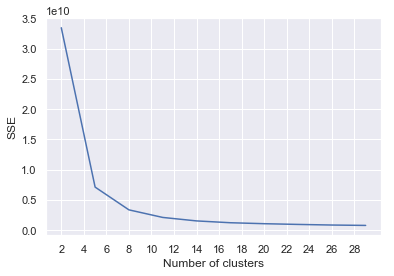

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(scores.number_of_clusters, scores.sse)
plt.xticks(np.arange(min(scores.number_of_clusters), max(scores.number_of_clusters)+1, 2))
plt.xlabel('Number of clusters')
plt.ylabel('SSE');

In [59]:
scores

,number_of_clusters,sse
0,2,33447430700.200
1,5,7138341301.173
2,8,3382313130.586
3,11,2131320418.419
4,14,1556804281.692
5,17,1256341462.123
6,20,1096845015.275
7,23,977990526.618
8,26,876774145.202
9,29,813527249.512


As Number of clusters on X axis increases, the centroids are closer to the clusters centroids. Idea number of clusters is when the SSE change is flat. That happens when the number of is 8 from the above plot

In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 8)
model = kmeans.fit(azdias_scaled_pca)
general_results_low_missing = model.predict(azdias_scaled_pca)

### Discussion 3.1: Apply Clustering to General Population

Created a funciton to get Sum of Squared errors for different number of clusters. Elbow method is used to identify ideal number of clusters. But, the elbow in the graph is not clearly visible.  Domain knowledge should help us in understanding the clusters better. But, for the sake of simiplicity and computational limits, I have choosen, 8 as number of clusters 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [62]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers, high_missing_cust_20 = clean_data(customers)
customers_pca = pca.transform(customers)
customers_pca = pd.DataFrame(customers_pca)
customers_pca = customers_pca.replace([np.inf, -np.inf], np.nan)
customers_pca = customers_pca.fillna(0)
results_low_missing = model.predict(customers_pca)

KK_KUNDENTYP           111937
KBA05_BAUMAX            55980
KBA05_ANTG4             55980
KBA05_ANTG3             55980
KBA05_ANTG2             55980
MOBI_REGIO              55980
KBA05_ANTG1             55980
KBA05_GBZ               55980
REGIOTYP                54260
KKK                     54260
W_KEIT_KIND_HH          53742
PLZ8_ANTG2              52764
PLZ8_ANTG1              52764
PLZ8_ANTG3              52764
PLZ8_ANTG4              52764
PLZ8_BAUMAX             52764
PLZ8_HHZ                52764
PLZ8_GBZ                52764
ANZ_HH_TITEL            52110
KBA13_ANZAHL_PKW        51281
RELAT_AB                50476
ORTSGR_KLS9             50476
ARBEIT                  50476
CAMEO_INTL_2015         50428
CAMEO_DEU_2015          50428
CAMEO_DEUG_2015         50428
BALLRAUM                49959
EWDICHTE                49959
INNENSTADT              49959
ANZ_HAUSHALTE_AKTIV     49927
GEBAEUDETYP             49927
MIN_GEBAEUDEJAHR        49927
OST_WEST_KZ             49927
WOHNLAGE  

OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
### Features with Object Datatype


OST_WEST_KZ        object
CAMEO_DEUG_2015    object
CAMEO_DEU_2015     object
CAMEO_INTL_2015    object
dtype: object

LP_LEBENSPHASE_FEIN : 40
LP_LEBENSPHASE_GROB : 12
WOHNLAGE : 8
PLZ8_BAUMAX : 5


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [63]:
customer_odd_cluster = np.array([-1] * high_missing_cust_20.shape[0])
general_odd_cluster = np.array([-1] * high_missing_20.shape[0])

In [64]:
# sorting missing values into a new cluster with -1 as identifier

results = np.concatenate((results_low_missing, customer_odd_cluster), axis = 0)
general_results = np.concatenate((general_results_low_missing, general_odd_cluster), axis = 0)

In [65]:
# Create comparision dataframe

customers_rep = pd.DataFrame(results)[0].value_counts()
customers_rep_perc = pd.DataFrame(results)[0].value_counts(normalize = True)
customers_rep = pd.DataFrame({'Count':customers_rep,'Perc':customers_rep_perc}, index =customers_rep.index )
#customers_rep.index.name = 'Customer Clusters'


general_rep = pd.DataFrame(general_results)[0].value_counts()
general_rep_perc = pd.DataFrame(general_results)[0].value_counts(normalize = True)
general_rep = pd.DataFrame({'Count':general_rep,'Perc':general_rep_perc}, index =general_rep.index )
#general_rep.index.name = 'Customer Clusters'

customers_rep['type'] = 'customers' 
general_rep['type'] = 'general' 

customers_rep = customers_rep.reset_index()
general_rep = general_rep.reset_index()

results_df = pd.concat([customers_rep,general_rep])
results_df = results_df.rename(columns = {'index':'cluster'})

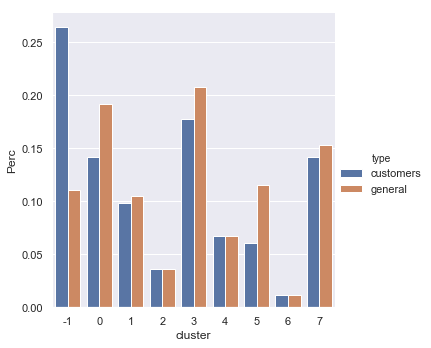

In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

sns.catplot(x='cluster', y='Perc', hue='type', data=results_df, kind='bar');

In [70]:
# # Rejoining odd cluster

general_final= pd.concat([low_missing_20, high_missing_20], sort = False)
customer_final = pd.concat([customers, high_missing_cust_20], sort = False)

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

def repr_mean(cluster, cust = True):
    low_missing_20['clusters'] = general_results_low_missing
    customers['clusters'] = results_low_missing
    if cust:
        cluster_5 = customer_final[customer_final['clusters'] == cluster]
        summary_cluster_5 = cluster_5.describe()
        s = summary_cluster_5.loc['mean'].sort_values(ascending = False)
    else: 
        cluster_5 = general_final[general_final['clusters'] == cluster]
        summary_cluster_5 = cluster_5.describe()
        s = summary_cluster_5.loc['mean'].sort_values(ascending = False)
    return s

In [78]:
g = repr_mean(cluster=0, cust = False)
c = repr_mean(cluster=0, cust = True)

cluster_summary = pd.DataFrame([g,c ]).T
cluster_summary.columns = ['general','customer']
cluster_summary

,general,customer
MIN_GEBAEUDEJAHR,1992.932,1992.815
KBA13_ANZAHL_PKW,374.735,377.669
decade,73.316,58.728
LP_LEBENSPHASE_FEIN,15.148,23.532
ANZ_HAUSHALTE_AKTIV,9.658,5.504
WOHNDAUER_2008,7.898,8.666
GFK_URLAUBERTYP,7.569,6.682
ORTSGR_KLS9,5.864,5.561
HH_EINKOMMEN_SCORE,4.679,3.480
REGIOTYP,4.645,4.065


In [79]:
g = repr_mean(cluster=3, cust = False)
c = repr_mean(cluster=3, cust = True)

cluster_summary = pd.DataFrame([g,c ]).T
cluster_summary.columns = ['general','customer']
cluster_summary

,general,customer
MIN_GEBAEUDEJAHR,1993.142,1992.965
KBA13_ANZAHL_PKW,525.163,526.079
decade,73.027,58.607
LP_LEBENSPHASE_FEIN,15.830,23.879
ANZ_HAUSHALTE_AKTIV,8.529,5.496
WOHNDAUER_2008,7.904,8.630
GFK_URLAUBERTYP,7.465,6.670
ORTSGR_KLS9,5.446,5.300
LP_LEBENSPHASE_GROB,4.753,7.067
LP_STATUS_FEIN,4.664,7.110


In [80]:
g = repr_mean(cluster=5, cust = False)
c = repr_mean(cluster=5, cust = True)

cluster_summary = pd.DataFrame([g,c ]).T
cluster_summary.columns = ['general','customer']
cluster_summary

,general,customer
MIN_GEBAEUDEJAHR,1993.247,1992.970
KBA13_ANZAHL_PKW,210.488,219.039
decade,73.647,59.789
LP_LEBENSPHASE_FEIN,14.840,22.553
ANZ_HAUSHALTE_AKTIV,10.326,6.601
WOHNDAUER_2008,7.882,8.618
GFK_URLAUBERTYP,7.611,6.713
ORTSGR_KLS9,5.749,5.560
clusters,5.000,5.000
HH_EINKOMMEN_SCORE,4.791,3.786


In [81]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


(high_missing_20.describe()).loc['mean'].sort_values(ascending = False).T

MIN_GEBAEUDEJAHR        2008.619
KBA13_ANZAHL_PKW         662.096
LP_LEBENSPHASE_FEIN       16.700
PRAEGENDE_JUGENDJAHRE      9.616
WOHNDAUER_2008             7.286
SEMIO_KRIT                 6.509
GFK_URLAUBERTYP            6.402
SEMIO_REL                  6.227
SEMIO_KAEM                 5.645
SEMIO_FAM                  5.565
SEMIO_DOM                  5.555
LP_LEBENSPHASE_GROB        5.080
SEMIO_MAT                  4.969
INNENSTADT                 4.954
LP_STATUS_FEIN             4.885
SEMIO_PFLICHT              4.839
ORTSGR_KLS9                4.717
CJT_GESAMTTYP              4.687
FINANZ_UNAUFFAELLIGER      4.670
FINANZ_ANLEGER             4.582
SEMIO_LUST                 4.503
BALLRAUM                   4.467
REGIOTYP                   4.121
SEMIO_RAT                  4.059
LP_FAMILIE_FEIN            4.031
ANZ_HAUSHALTE_AKTIV        4.019
GEBAEUDETYP_RASTER         3.924
FINANZTYP                  3.675
FINANZ_SPARER              3.674
PLZ8_GBZ                   3.652
PLZ8_HHZ  

In [82]:
(high_missing_cust_20.describe()).loc['mean'].sort_values(ascending = False).T

MIN_GEBAEUDEJAHR        2007.927
KBA13_ANZAHL_PKW         724.858
LP_LEBENSPHASE_FEIN       25.170
WOHNDAUER_2008             8.013
LP_LEBENSPHASE_GROB        7.587
SEMIO_KRIT                 6.792
SEMIO_REL                  6.685
LP_FAMILIE_FEIN            6.101
SEMIO_FAM                  5.866
SEMIO_KAEM                 5.824
SEMIO_DOM                  5.821
ANZ_HAUSHALTE_AKTIV        5.647
CJT_GESAMTTYP              5.449
PRAEGENDE_JUGENDJAHRE      5.438
GFK_URLAUBERTYP            5.348
LP_STATUS_FEIN             5.330
ORTSGR_KLS9                5.154
SEMIO_MAT                  5.003
SEMIO_LUST                 4.929
SEMIO_PFLICHT              4.924
FINANZ_UNAUFFAELLIGER      4.832
INNENSTADT                 4.794
FINANZ_ANLEGER             4.769
BALLRAUM                   4.364
EWDICHTE                   3.956
REGIOTYP                   3.949
SEMIO_RAT                  3.944
FINANZTYP                  3.892
PLZ8_GBZ                   3.827
FINANZ_SPARER              3.801
GEBAEUDETY

Only customers in cluter -1 are over represented in customer data compared to general population

### Discussion 3.3: Compare Customer Data to Demographics Data

Here, the cluster are pretty similar to each other when compared to customers and general population data set, except for cluster number
0,3,5,-1 . In cluster 0, customers are overrepresented while in cluster -1, customers are under represented by a lot.Customers in Cluster -1 is basically has dismilar life stages compared to general population, who are highly likely to be membership in environmental sustainability as part of youth


I have taken mean of the features to see any siginificant difference in features.Cluster 3 has more cars (`KBA13_ANZAHL_PKW`) on an average compared to 0 & 5. Also, cluster 1 customers are older compared to general population

This might indicate population density or wealth of the customers in that clusters.I am incliend towards thinking cluster 0 people are far from city center because `INNENSTADT` is 23% higher than other two over represented clusters.  

In cluster 0, `LP_LEBENSPHASE_FEIN` is a feature that is significantly different from general population which indicates that life stage aspects of this cluster is very different. Also, companies customers have nearly 1.5X more households with income lower by 24%. This might incidate these customers with many households and low household income are overal lower or middle class income groups. This pattern is consistent with cluster number 5 & 0 as well. from `WOHNDAUER_2008`, we can see that customers are basically long living residents in over represented clusters. As length of stay is more, they are looking like they tend to be more likely(10% more likely) to be customers. So, relativley newly moved customers might be a target for the company.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.